## MODELOS ARIMA & LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

: 

Se lee la data "original" de Demanda en sector eléctrico

In [ ]:
demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
demanda_electrico_original

: 

Se grafica la data "original" de Demanda en sector eléctrico

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

: 

Se descompone la data "original" de Demanda en sector eléctrico en sus compoentes de Tendencia, Estacionalidad y Residual

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_original_seasonal_decomposition = seasonal_decompose(demanda_electrico_original)
demanda_electrico_original_seasonal_decomposition.plot()

: 

Separamos la data original de Demanda de gas natural en el sector eléctrico en data de train y test

In [ ]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_original_train_data = demanda_electrico_original[:-num_test_points]
demanda_electrico_original_test_data = demanda_electrico_original[-num_test_points:]

demanda_electrico_original_train_data

: 

Se grafica la distribución de los datos "originales escalados" de train de Demanda en sector eléctrico

In [ ]:
# Generate the histogram
plt.hist(demanda_electrico_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos originales escalados"')

# Display the plot
plt.show()

: 

In [ ]:
demanda_electrico_original_train_data.describe()

: 

Se lleva a cabo una prueba de normalidad a los datos "originales escalados" de train de Demanda en sector eléctrico

In [ ]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_original_train_data

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

: 

In [ ]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

: 

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

: 

In [ ]:
demanda_electrico_original_train_data["Demanded_Gas"]

: 

In [ ]:
n_input = 24

data = demanda_electrico_original_train_data["Demanded_Gas"]
targets = data 


demanda_electrico_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

: 

In [ ]:
demanda_electrico_original_train_generator[176]

: 

In [ ]:
print("Total number of samples in the original training data = ", len(demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_original_train_generator))


: 

### Se define y entrena la red neuronal FFNN  para el caso de la data original de Demanda en el sector eléctrico

In [ ]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

: 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

: 

Se define la red neuronal FFNN con capas densas y funcion de activación tipo RELU.

In [ ]:
n_input = 24
n_features = 1

# define model
model_FF_electrico_sin_tratamiento = Sequential()
model_FF_electrico_sin_tratamiento.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_electrico_sin_tratamiento.add(Dense(32, activation='relu'))
model_FF_electrico_sin_tratamiento.add(Dense(1))
model_FF_electrico_sin_tratamiento.compile(optimizer='Adam', loss='mse')

: 

In [ ]:
model_FF_electrico_sin_tratamiento.summary()

: 

In [ ]:
model_FF_electrico_sin_tratamiento.fit(demanda_electrico_original_train_generator, epochs=12)

: 

In [ ]:
loss_per_epoch_model_FF = model_FF_electrico_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

: 

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [ ]:
n_input = 24
n_features = 1

: 

In [ ]:
test_predictions_model_FF_electrico_sin_pretratamiento = []

first_eval_batch = demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_FF_electrico_sin_tratamiento.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_electrico_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

: 

In [ ]:
test_predictions_model_FF_electrico_sin_pretratamiento

: 

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_FF_electrico_sin_pretratamiento, color='#94E844')
plt.legend(('Data', 'Forecast modelo FFNN sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo FFNN data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector eléctrico

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [ ]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

: 

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [ ]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico = Sequential()
model_LSTM_electrico.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico.add(Dense(1))
model_LSTM_electrico.compile(optimizer='adam', loss='mse')

: 

In [ ]:
model_LSTM_electrico.summary()

: 

Entrenamos el modelo LSTM

In [ ]:
model_LSTM_electrico.fit(demanda_electrico_original_train_generator, epochs=12)


: 

Se grafica la perdida por epoch

In [ ]:
loss_per_epoch_model_FF = model_LSTM_electrico.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

: 

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_electrico_sin_tratamiento previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [ ]:
## demanda_electrico_original_train_generator[-24]

: 

In [ ]:
''' 

data = demanda_electrico_original_train_generator

demanda_electrico_train_batch = data[-n_input:]

demanda_electrico_train_batch

'''

: 

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [ ]:
'''

demanda_electrico_train_batch_reshaped = demanda_electrico_train_batch.reshape(1,n_input, n_features)
demanda_electrico_train_batch_reshaped

'''

: 

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [ ]:
'''
model_LSTM_electrico.predict(demanda_electrico_train_batch_reshaped)

'''

: 

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos de test de la demanda de gasd natural en sector eléctrico

In [ ]:
'''
demanda_electrico_original_test_data[0]

'''

: 

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [ ]:
n_input = 24
n_features = 1

: 

In [ ]:
first_eval_batch = demanda_electrico_original_train_data[-n_input:]
first_eval_batch

: 

In [ ]:
test_predictions_model_LSTM_electrico = []

first_eval_batch = demanda_electrico_original_train_data[-n_input:]["Demanded_Gas"].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

: 

In [ ]:
test_predictions_model_LSTM_electrico

: 

Se grafican los 12 meses de test vs el forecast del modelo LSTM con la data de entrenamiento normalizada con MinMaxScaler()

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

Se calcula el error de pronóstico para los 12 meses de test con  modelo FFNN sin la data pretratada

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_electrico = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico)
RMSE_predictions_model_LSTM_electrico= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico))

print('MAPE:', MAPE_predictions_model_LSTM_electrico)
print('RMSE:', RMSE_predictions_model_LSTM_electrico)

: 

### Se define y entrena modelo ARIMA para el caso de la data original de Demanda en el sector eléctrico

In [ ]:
##Create the model
model_ARIMA_electrico_original = ARIMA (demanda_electrico_original_train_data, order=(4,1,4))

##Fit the model
start = time()
model_ARIMA_electrico_original_fit = model_ARIMA_electrico_original.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_original_fit.summary())

: 

In [ ]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

##get the predictors and residuals 
predictions_model_ARIMA_electrico_original = model_ARIMA_electrico_original_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
predictions_model_ARIMA_electrico_original


: 

In [ ]:
test_predictions_model_LSTM_electrico

: 

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento', 'Forecast modelo ARIMA sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM y ARIMA data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [ ]:
outlier_threshold = 1.25

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

: 

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [ ]:
demanda_electrico_original_train_para_tratamiento =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento

: 

In [ ]:
demanda_electrico_train_pretratamiento_media = remove_replace_outliers_media(demanda_electrico_original_train_para_tratamiento['Demanded_Gas'])
demanda_electrico_train_pretratamiento_media

: 

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales y atípicos tratados con la media"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

: 

In [ ]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

: 

In [ ]:
demanda_electrico_train_pretratamiento_media.describe()

: 

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector eléctrico para el caso de pretratamiento con la media artimetica

In [ ]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

: 

Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

In [ ]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

: 

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [ ]:
n_input = 24

data = demanda_electrico_train_pretratamiento_media
targets = data 

demanda_electrico_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


: 

In [ ]:
demanda_electrico_train_generator_pretratamiento_media[0]

: 

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [ ]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_media)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_media))

: 

Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [ ]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)



: 

In [ ]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_pretratamiento_media = Sequential()
model_LSTM_electrico_pretratamiento_media.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretratamiento_media.add(Dense(1))
model_LSTM_electrico_pretratamiento_media.compile(optimizer='adam', loss='mse')

: 

In [ ]:
model_LSTM_electrico_pretratamiento_media.summary()

: 

Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [ ]:
model_LSTM_electrico_pretratamiento_media.fit(demanda_electrico_train_generator_pretratamiento_media, epochs=12)

: 

Se grafica la perdida por epoch 

In [ ]:
loss_per_epoch = model_LSTM_electrico_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

: 

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [ ]:
demanda_electrico_train_batch_pretratamiento_media = demanda_electrico_train_pretratamiento_media[-n_input:]


demanda_electrico_train_batch_pretratamiento_media

: 

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [ ]:
demanda_electrico_train_batch_pretratamiento_media_reshaped = demanda_electrico_train_batch_pretratamiento_media.values.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_media_reshaped

: 

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [ ]:
model_LSTM_electrico_pretratamiento_media.predict(demanda_electrico_train_batch_pretratamiento_media_reshaped)

: 

Y se compara el valor de forecast del modelo LSTM + pretratamiento media + normalizacion con los datos de test de la demanda de gas natural en sector eléctrico

In [ ]:
demanda_electrico_original_test_data

: 

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [ ]:
n_input = 24
n_features = 1

: 

In [ ]:
demanda_electrico_train_pretratamiento_media[-n_input:]

: 

In [ ]:
test_predictions_model_LSTM_electrico_pretratamiento_media  = []

first_eval_batch = demanda_electrico_train_pretratamiento_media[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

: 

In [ ]:
test_predictions_model_LSTM_electrico_pretratamiento_media

: 

In [ ]:
demanda_electrico_original_test_data['Demanded_Gas'].values

: 

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM pretratamiento de atipicos con media '))

plt.title('Demanda sector electrico con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media)

: 

Se muestra la comparación del forecast de demanda electrico con modelo FFNN entre train data sin pretratamiento y con pretratamiento de atípicos con la media

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

Apliquemos un modelo ARIMA a nuestra data de Demanda de gas natural en sector eléctrico 'Datos atipicos con tratamiento media'

In [ ]:
##Create the model
model_ARIMA_electrico_tratamiento_media = ARIMA (demanda_electrico_train_pretratamiento_media, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_electrico_tratamiento_media_fit = model_ARIMA_electrico_tratamiento_media.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_tratamiento_media_fit.summary())

: 

In [ ]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

: 

In [ ]:
##get the predictors and residuals 
predictions_model_ARIMA_electrico_tratamiento_media = model_ARIMA_electrico_tratamiento_media_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
print(predictions_model_ARIMA_electrico_tratamiento_media)

: 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_electrico_tratamiento_media = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_media)
RMSE_predictions_model_ARIMA_electrico_tratamiento_media= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_media))

print('MAPE:', MAPE_predictions_model_ARIMA_electrico_tratamiento_media)
print('RMSE:', RMSE_predictions_model_ARIMA_electrico_tratamiento_media)

: 

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(predictions_model_ARIMA_electrico_tratamiento_media.values,color='#43C104')
plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento', 'Forecast con modelo ARIMA pretratamiento de atipicos (media)','Forecast con modelo ARIMA sin pretratamiento ' ), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media) vs ARIMA sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [ ]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

: 

In [ ]:
demanda_electrico_original_train_para_tratamiento2 =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento2

: 

In [ ]:
demanda_electrico_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_electrico_original_train_para_tratamiento2['Demanded_Gas'])
demanda_electrico_train_pretratamiento_mediana

: 

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.plot(demanda_electrico_train_pretratamiento_mediana, color= '#08D691')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con mediana'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales" vs tratados con la mediana y la media', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

: 

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_electrico_train_pretratamiento_mediana)
demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition.plot()


: 

In [ ]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

: 

In [ ]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_pretratamiento_mediana)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

: 

In [ ]:
demanda_electrico_train_pretratamiento_mediana.describe()

: 

In [ ]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

: 

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [ ]:
n_input = 24

data = demanda_electrico_train_pretratamiento_mediana
targets = data 

demanda_electrico_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_electrico_train_generator_pretratamiento_mediana[0]

: 

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [ ]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_mediana))

: 

Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [ ]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_pretrataminto_mediana = Sequential()

model_LSTM_electrico_pretrataminto_mediana.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretrataminto_mediana.add(Dense(1))
model_LSTM_electrico_pretrataminto_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_electrico_pretrataminto_mediana.summary()

: 

Se entrena el modelo 

In [ ]:
model_LSTM_electrico_pretrataminto_mediana.fit(demanda_electrico_train_generator_pretratamiento_mediana, epochs=15)

: 

In [ ]:
loss_per_epoch = model_LSTM_electrico_pretrataminto_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

: 

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [ ]:
demanda_electrico_train_pretratamiento_mediana

: 

In [ ]:
demanda_electrico_train_batch_pretratamiento_mediana = demanda_electrico_train_pretratamiento_mediana[-n_input:]


demanda_electrico_train_batch_pretratamiento_mediana

: 

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [ ]:
demanda_electrico_train_batch_pretratamiento_mediana_reshaped = demanda_electrico_train_batch_pretratamiento_mediana.values.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_mediana_reshaped

: 

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [ ]:
model_LSTM_electrico_pretrataminto_mediana.predict(demanda_electrico_train_batch_pretratamiento_mediana_reshaped)

: 

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [ ]:
n_input = 24
n_features = 1

: 

In [ ]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana  = []

first_eval_batch = demanda_electrico_train_pretratamiento_mediana[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretrataminto_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

: 

In [ ]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana

: 

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07' )
plt.legend(('Data original', 'Modelo LSTM sin pretratamiento', 'Modelo LSTM con pretratamiento media', 'Modelo LSTM con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector electrico con modelo LSTM comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)

: 

Modelo ARIMA para el caso del pretratamiento de datos con la mediana 

In [ ]:
##Create the model
model_ARIMA_electrico_tratamiento_mediana = ARIMA (demanda_electrico_train_pretratamiento_mediana, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_electrico_tratamiento_mediana_fit = model_ARIMA_electrico_tratamiento_mediana.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_tratamiento_mediana_fit.summary())

: 

In [ ]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

: 

In [ ]:
##get the predictors and residuals 
predictions_model_ARIMA_electrico_tratamiento_mediana = model_ARIMA_electrico_tratamiento_mediana_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
print(predictions_model_ARIMA_electrico_tratamiento_mediana)

: 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_electrico_tratamiento_mediana = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_mediana)
RMSE_predictions_model_ARIMA_electrico_tratamiento_mediana= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_mediana))

print('MAPE:', MAPE_predictions_model_ARIMA_electrico_tratamiento_mediana)
print('RMSE:', RMSE_predictions_model_ARIMA_electrico_tratamiento_mediana)

: 

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')


plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')

plt.plot(predictions_model_ARIMA_electrico_tratamiento_media.values,color='#43C104')
plt.plot(predictions_model_ARIMA_electrico_tratamiento_mediana.values, color='#97FEFB')


plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial','Forecast con modelo ARIMA sin pretratamiento','Forecast con modelo ARIMA pretratamiento media aritmética', 'Forecast con modelo ARIMA pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo ARIMA sin pretratamiento y con pretratamiento (media aritmética y mediana ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')

plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07')

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial', 'Forecast con modelo LSTM sin pretratamiento','Forecast con modelo LSTM pretratamiento media aritmética',  'Forecast con modelo LSTM pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media aritmética y mediana)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

: 

Text(0, 0.5, 'Demanda [MMpcd]')

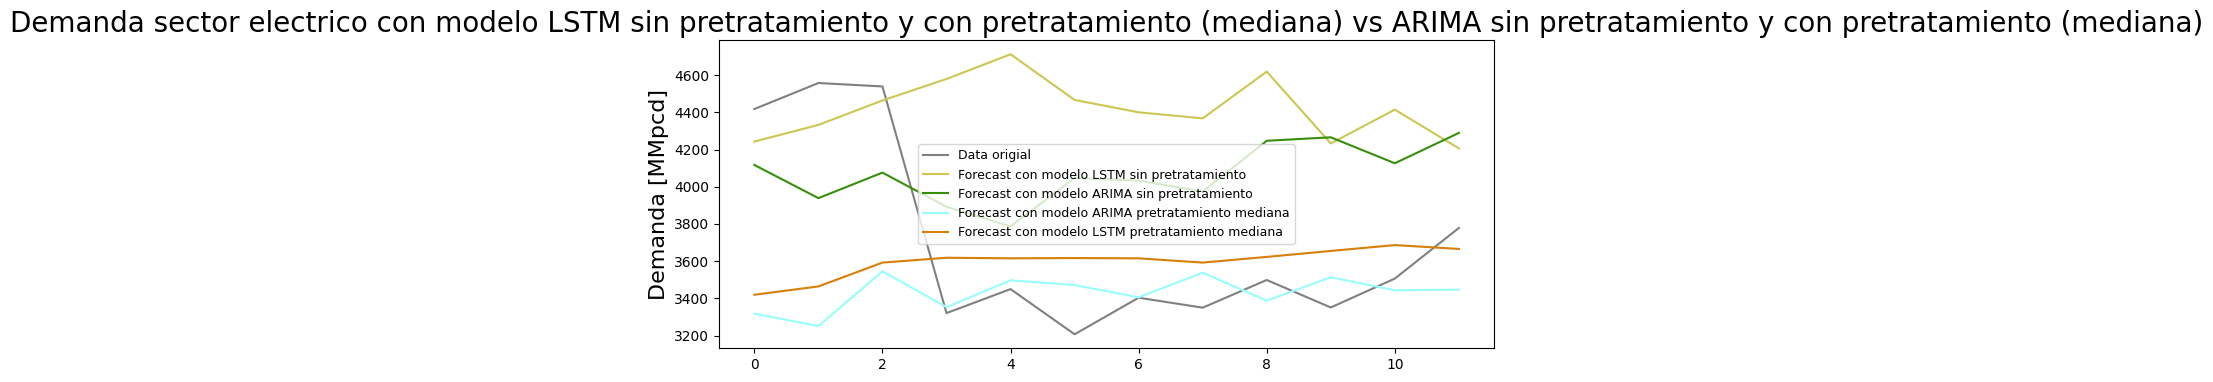

In [109]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')


plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')


plt.plot(predictions_model_ARIMA_electrico_tratamiento_mediana.values, color='#97FEFB')

plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07')

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial', 'Forecast con modelo LSTM sin pretratamiento','Forecast con modelo ARIMA sin pretratamiento', 'Forecast con modelo ARIMA pretratamiento mediana' , 'Forecast con modelo LSTM pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (mediana) vs ARIMA sin pretratamiento y con pretratamiento (mediana)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)